<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_VAE/blob/master/1_multilayer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multilayer Perceptron (MLP)**
A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN).

Use MLP for MNIST classification.

In [ ]:
import numpy as np
import tensorflow as tf

###**Set training parameters**


In [ ]:
# Parameters
learning_rate = 0.001
training_epochs = 3000
batch_size = 100
display_step = 300

###**Load MNIST data**
Set train & test data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11493376/11490434 [==============================] - 0s 0us/step


###**Set model**
Two-layered MLP.

> $h_1 = S(W_1 x + b_1)$ 

> $h_2 = S(W_2 h_1 + b_2)$ 

> $\hat{y} = \sigma(W_3 h_2 + b_3)$

*   $x$ : input (image)
*   $y$ : output (label)
*   $S(z) = \frac{1}{1+exp(-z)}$ : sigmoid function
*   $\sigma(z) = \frac{\exp(z_i)}{\sum_{i}\exp(z_i)}$ : softmax function

In [ ]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [ ]:
# Store layers weight & bias
weights = {
    'W1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'W2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'W3': tf.Variable(tf.random.normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'b3': tf.Variable(tf.random.normal([n_classes]))
}

In [ ]:
# Create model
def multilayer_perceptron(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['W1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['W2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    layer_2 = tf.nn.sigmoid(layer_2)
    output = tf.matmul(layer_2, weights['W3']) + biases['b3']
    return tf.nn.softmax(output)

###**Train model**

* **Method**: Stochastic Gradient Descent (SGD)
* **Loss function**: Binary cross-entropy  
> $l(y,\hat{y}) = -\frac{1}{d} \sum_{i=1}^{d} y_i \cdot \log{\hat{y}_i} + (1-y_i) \cdot \log{(1-\hat{y}_i)}$
, where $d$ is output dimension.

In [ ]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=10)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
# Optimization process. 
def train_step(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as tape:
        pred = multilayer_perceptron(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = tape.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_epochs), 1):
    # Run the optimization to update W and b values.
    train_step(batch_x, batch_y)
    
    if (step+1) % display_step == 0:
        pred = multilayer_perceptron(batch_x)
        loss  = cross_entropy(pred, batch_y)
        acc  = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step+1, loss, acc))

step: 300, loss: 77.868912, accuracy: 0.800000
step: 600, loss: 60.735500, accuracy: 0.780000
step: 900, loss: 73.050545, accuracy: 0.760000
step: 1200, loss: 38.587265, accuracy: 0.870000
step: 1500, loss: 48.342949, accuracy: 0.860000
step: 1800, loss: 33.105919, accuracy: 0.940000
step: 2100, loss: 35.929817, accuracy: 0.890000
step: 2400, loss: 36.794552, accuracy: 0.840000
step: 2700, loss: 27.622402, accuracy: 0.900000
step: 3000, loss: 44.290558, accuracy: 0.870000


###**Test model**
Test trained MLP model.

In [ ]:
# Select test data
num_test_sel = 4
num_test = x_test.shape[0]
idx_rand = np.random.permutation(np.arange(0, num_test))
idx_rand_sel = idx_rand[0:num_test_sel]

x_sel = x_test[idx_rand_sel, :]
y_sel = y_test[idx_rand_sel]

x_in = tf.reshape(x_sel, [-1, 784])
y_out = multilayer_perceptron(x_in)
y_out = y_out.numpy()
y_sel_pred = np.argmax(y_out, axis=1)

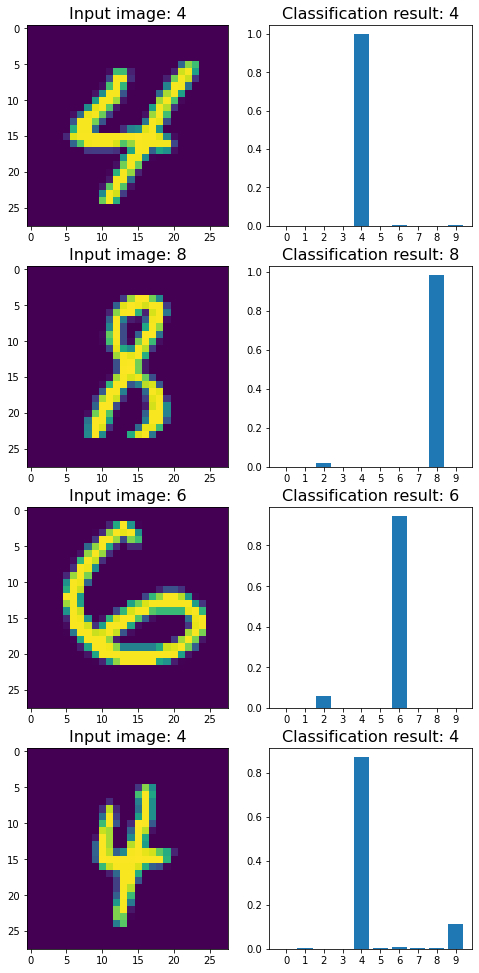

In [ ]:
# Plot test result
import matplotlib.pyplot as plt
from matplotlib import gridspec
barx = np.arange(0,10)

fig = plt.figure(figsize=(8, 4.25 * num_test_sel)) 
gs = gridspec.GridSpec(nrows=num_test_sel,
                       ncols=2,
                       height_ratios=[1]*num_test_sel, 
                       width_ratios=[1, 1]
                       )

for nidx_d in range(0, num_test_sel):
  _x_sel_plot = x_sel[nidx_d, :]
  x_sel_plot = np.reshape(_x_sel_plot, (28, 28))
  y_sel_plot = y_sel[nidx_d]
  y_out_plot = y_out[nidx_d, :]
  y_sel_pred_plot = y_sel_pred[nidx_d]
  ax0 = plt.subplot(gs[nidx_d, 0])
  ax0.imshow(x_sel_plot)
  ax0.title.set_text('Input image: {:d}'.format(y_sel_plot))
  ax0.title.set_fontsize(16)

  ax1 = plt.subplot(gs[nidx_d, 1])
  ax1.bar(barx, y_out_plot.reshape(-1))
  plt.xticks(barx)
  ax1.title.set_text('Classification result: {:d}'.format(y_sel_pred_plot))
  ax1.title.set_fontsize(16)

plt.show()